# W207 Final Project - Santander Customer Churn
W207 | Section 3 | Group 2 | Fall 2018 | Michael Ballschmiede, Kathryn Papandrew, Praba Santhanakrishnan


# 1. Introduction

Santander is trying to get proactive against losing customers. They are trying to compete with other credit card offerings and want to know which customers they're most susceptible to losing to their competitors. 

To that end, they have commissioned us to transform their glut of data into a more manageable, user-friendly analysis of customer churn. The goal is to be able to identify the likelihood a customer will stop using credit card services to be able to offer a promotional offer of Santander's choosing to entice them to stay. The term for a customer leaving is "churn" and will be used throughout this report to describe the phenomena being modeled. 

The research question our team is trying to answer is how likely is a credit card customer to churn in a given month? The likelihood of the churn will drive how significant of an offer to provide to that customer. 

## 1.1 Load in the data

In [2]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) 
pd.set_option('display.max_columns', None)

/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


When loading in the data, due to the sheer volume of data present in our training file, we limit the rows to the top 7,000,000 due to processing constraints on our local machines. Ideally, we'd be able to have this file in the cloud and harness parallel computing to run transformations or aggregations for EDA to more strategically subset the data. 

In [3]:
# Set your local directory to have the file in it
# Limit the rows in the large file to 7,000,000. 
limit_rows = 7000000
df  = pd.read_csv("W207_Section3_Group2_Data.csv",
                           dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str}, nrows=limit_rows)

/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. Methods

## 2.1 Exploratory Data Analysis

The data used came from Santander for the aforementioned Kaggle competition. The data has 30 features and all columns are in their native Spanish nomenclature. In order to make it simpler for our audience to interpret, we translated the columns into English. 

### 2.1.1 Data Initial Analysis & Scrubbing

In [4]:
df = df.rename(columns={'fecha_dato': 'partition', 'ncodpers': 'customer_code', 'ind_empleado': 'employee_index', 
                        'pais_residencia': 'country_residence', 'sexo': 'gender', 'age': 'age', 
                        'fecha_alta': 'customer_start_date', 'ind_nuevo': 'new_customer_index', 
                        'antiguedad': 'customer_seniority', 'indrel': 'primary_customer', 
                        'ult_fec_cli_1t': 'primary_customer_last_date', 'indrel_1mes': 'customer_type', 
                        'tiprel_1mes': 'customer_relation_type', 'indresi': 'residence_index', 
                        'indext': 'foreigner_index', 'conyuemp': 'spouse_index', 'canal_entrada': 'join_channel', 
                        'indfall': 'deceased_index', 'tipodom': 'address_type', 'cod_prov': 'province_code', 
                        'nomprov': 'province_name', 'ind_actividad_cliente': 'activity_index', 'renta': 'gross_income',
                        'segmento': 'segmentation', 'ind_ahor_fin_ult1': 'savings_account', 
                        'ind_aval_fin_ult1': 'guarantees', 'ind_cco_fin_ult1': 'current_account', 
                        'ind_cder_fin_ult1': 'derivada_account', 'ind_cno_fin_ult1': 'payroll_account', 
                        'ind_ctju_fin_ult1': 'junior_account', 'ind_ctma_fin_ult1': 'another_particular_account', 
                        'ind_ctop_fin_ult1': 'particular_account', 'ind_ctpp_fin_ult1': 'particular_plus_account', 
                        'ind_deco_fin_ult1': 'short_term_deposit', 'ind_deme_fin_ult1': 'medium_term_deposit', 
                        'ind_dela_fin_ult1': 'long_term_deposit', 'ind_ecue_fin_ult1': 'e_account', 
                        'ind_fond_fin_ult1': 'funds', 'ind_hip_fin_ult1': 'mortgage', 'ind_plan_fin_ult1': 'pensions1',
                        'ind_pres_fin_ult1': 'loans', 'ind_reca_fin_ult1': 'taxes', 'ind_tjcr_fin_ult1': 'credit_card',
                        'ind_valo_fin_ult1': 'securities', 'ind_viv_fin_ult1': 'home_account', 
                        'ind_nomina_ult1': 'payroll', 'ind_nom_pens_ult1': 'pensions2', 'ind_recibo_ult1': 'direct_debit'})

Again, we are faced with limitations on processing power with our local machines. In order to make the models performant for the purposes of this lab, we subsetted the data with a sample of 135,000 unique customer IDs. That way, we have consistent data throughout but have a smaller dataset to work with that will still be able to be used to train and predict once our models have been fitted.

In [5]:
# Customer codes
print('Total rows in dataset: ', df["customer_code"].count())
print('Total customer in dataset: ', len(df["customer_code"].unique()))
print('Average number of months (rows) per customer:', (df["customer_code"].count() / len(df["customer_code"].unique())))

Total rows in dataset:  7000000
Total customer in dataset:  903811
Average number of months (rows) per customer: 7.7449820814307415


In [6]:
unique_ids   = pd.Series(df["customer_code"].unique())
unique_id    = unique_ids.sample(n=135000)
df           = df[df.customer_code.isin(unique_id)]
df.describe()

,customer_code,primary_customer,address_type,province_code,activity_index,gross_income,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
count,1.045377e+06,1.041098e+06,1041098.0,1.035468e+06,1.041098e+06,8.586320e+05,1.045377e+06,1045377.0,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.045377e+06,1.042888e+06,1.042888e+06,1.045377e+06
mean,8.048070e+05,1.144680e+00,1.0,2.656340e+01,4.905821e-01,1.336386e+05,7.270104e-05,0.0,7.038743e-01,4.323799e-04,8.573271e-02,1.057322e-02,9.707503e-03,1.473067e-01,4.849447e-02,2.873604e-03,1.939013e-03,4.898903e-02,8.836525e-02,2.127271e-02,6.545007e-03,1.011692e-02,2.790381e-03,5.667525e-02,5.085247e-02,2.787128e-02,4.689217e-03,5.914825e-02,6.429645e-02,1.367765e-01
std,4.227022e+05,3.762674e+00,0.0,1.273255e+01,4.999115e-01,2.069421e+05,8.526185e-03,0.0,4.565473e-01,2.078926e-02,2.799691e-01,1.022812e-01,9.804732e-02,3.544115e-01,2.148087e-01,5.352896e-02,4.399154e-02,2.158452e-01,2.838255e-01,1.442921e-01,8.063607e-02,1.000729e-01,5.275033e-02,2.312211e-01,2.196965e-01,1.646041e-01,6.831715e-02,2.359021e-01,2.452804e-01,3.436114e-01
min,1.589300e+04,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.191760e+05,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.908340e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.223630e+05,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.021538e+05,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.171106e+06,1.000000e+00,1.0,3.400000e+01,1.000000e+00,1.566070e+05,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.495462e+06,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


After an initial glance at the data, we note that we need to transform some of our variables' data types to make them workable for what we intuitively intend to be gleaning from those features. We also need to set invalid values to  `NaN`

In [7]:
# Change datatype, setting invalid values to NaN

# Age
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# Customer seniority
df["customer_seniority"] = pd.to_numeric(df["customer_seniority"], errors="coerce") 

# Customer type at beginning of month
df["customer_type"] = pd.to_numeric(df["customer_type"], errors="coerce") 

# Convert row-identifier date to datatime64 format
df["partition"] = pd.to_datetime(df["partition"],format="%Y-%m-%d")

# Convert date that customer joined to datatime64 format
df["customer_start_date"] = pd.to_datetime(df["customer_start_date"],format="%Y-%m-%d")

# Convert last date as primary customer to datatime64 format
df["primary_customer_last_date"] = pd.to_datetime(df["primary_customer_last_date"],format="%Y-%m-%d")


# Antiguedad, or customer seniority (in months)
df['customer_seniority'] = pd.to_numeric(df['customer_seniority'],errors="coerce")

Now that some initial scrubbing has been done, we'll see which features we want to keep in the dataset by first checking out which have the most missing values / sparsity. The code below shows us the number of missing values in each column.

In [8]:
df.isnull().sum()

partition                           0
customer_code                       0
employee_index                   4279
country_residence                4279
gender                           4289
age                              4279
customer_start_date              4279
new_customer_index               4279
customer_seniority               4279
primary_customer                 4279
primary_customer_last_date    1043840
customer_type                   15917
customer_relation_type          15861
residence_index                  4279
foreigner_index                  4279
spouse_index                  1045235
join_channel                    18043
deceased_index                   4279
address_type                     4279
province_code                    9909
province_name                    9909
activity_index                   4279
gross_income                   186745
segmentation                    18193
savings_account                     0
guarantees                          0
current_acco

We see that two of our columns have > 99% null values: `primary_customer_last_date` and `spouse_index`. 

The first of these is `primary_customer_last_date`, or the last date as primary customer (if he or she isn't at end of month). Let's take a closer look at how many non-null values we have in a given time range. As we see below, there are not many non-null values so we can either binarize this feature's data or delete the column. While the above gives us a nice understanding of when some of our customers dropped from primary status, we choose to delete the column as we have questions about data quality and relevance for our research question. 

In [9]:
df["primary_customer_last_date"].value_counts().head()

2015-07-06    70
2015-07-01    62
2015-07-20    62
2015-07-28    57
2015-07-23    54
Name: primary_customer_last_date, dtype: int64

The second column with > 99% null values is `spouse index`, defined  as: 
```
1 if customer is spouse of employee 
```
We don't intuitively expect to gain much from this column for modeling purposes, especially in its given state. The only piece that may make this data useful later is determining whether the account holder is eligible for a special promotion. There are many restriction around promotions for those related to an employee. Let's take a closer look:

In [10]:
df["spouse_index"].value_counts()

N    142
Name: spouse_index, dtype: int64

In [11]:
df["deceased_index"].value_counts()

N    1038407
S       2691
Name: deceased_index, dtype: int64

We decide that both should be deleted for modeling purposes as they are not variables of interest for credit card holders who will potentially churn. Similarly, while we do have a fair number of 'deceased' customer rows in our dataset, we want to delete these for a couple of reasons. First off, we will not be expecting or predicting deceased customers to purchase new products. Leaving these rows in our dataset could also serve to introduce additional random noise, as our models try to make correlations and connections that clearly do not exist.

In [12]:
# Delete rows from deceased customers
df = df[df['deceased_index'] != 'S']

# Delete above columns
df = df.drop(["primary_customer_last_date", "spouse_index", "deceased_index"], axis=1) 

There is another variable of interest in our dataset that doesn't seem to hold much meaning. This feature is `address_type`. This variable seems to describe which address is on their account, such a primary address, secondary address, etc...  The code below describes which values this variable takes on in the data. 

In [13]:
df["address_type"].value_counts()

1.0    1038407
Name: address_type, dtype: int64

The only value we see for this variable is 1. Because this doesn't give us much insight, in addition to the fact that it's constant for all observations, we'll air on the side of parsimony and remove this column, as well. 

In [14]:
df = df.drop(["address_type"], axis=1) 

We notice above that we have exactly the same number of null values for several of our variables in the above `isnull()` table. Let's take a closer look at rows with null seniority values


In [15]:
df[df['customer_seniority'].isnull()]

,partition,customer_code,employee_index,country_residence,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_type,customer_relation_type,residence_index,foreigner_index,join_channel,province_code,province_name,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
261,2015-01-28,1050741,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
5288,2015-01-28,1043686,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
5503,2015-01-28,1045095,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
6196,2015-01-28,1042585,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
11198,2015-01-28,1064250,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
11270,2015-01-28,1064139,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
11740,2015-01-28,1064702,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13310,2015-01-28,1069167,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
15474,2015-01-28,1060408,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
15744,2015-01-28,1059938,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0


A quick scan shows that these rows can all be deleted altogether as they're comprised exclusively of null values.

We also noticed above in our summary table that for `customer_seniority`, there are values less than 0. This is by definition not possible, and thus we delete these rows as they comprise a tiny proportion of our dataset and we cannot be certain about the quality of their other columns.

In [16]:
df = df[df['customer_seniority'].notnull()]

# Delete rows with seniority < 0. Note that this is a tiny proportion of our customers
df = df[df["customer_seniority"] > 0]
print('# of null values:' , np.sum(df["customer_seniority"].isnull()))

# of null values: 0


We next take a look at `province_code`, which denotes customer province codes

In [17]:
df["province_code"].value_counts().head(10)

28.0    333978
8.0      93621
46.0     49255
41.0     46627
15.0     32423
30.0     29331
29.0     28592
50.0     25634
11.0     23009
3.0      22055
Name: province_code, dtype: int64

We want to confirm that this variable is indeed redundant with `province_name`

In [18]:
df[df["province_code"] == 28]["province_name"].value_counts()

MADRID    333978
Name: province_name, dtype: int64

Confirmed that all rows with province code = 28 correspond to 'Madrid'. We will (later) delete our 'province name' variable. Let's first look at our null province values. 


In [19]:
np.sum(df["province_code"].isnull())

5373

In [20]:
# Taking a closer look
df[df['province_name'].isnull()].head(10)

,partition,customer_code,employee_index,country_residence,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_type,customer_relation_type,residence_index,foreigner_index,join_channel,province_code,province_name,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
5907,2015-01-28,1044441,N,IE,V,28.0,2012-08-06,0,35.0,1.0,1.0,A,N,N,KFC,NaN,NaN,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0.0,0
48362,2015-01-28,1101186,N,CH,V,41.0,2012-11-15,0,32.0,1.0,1.0,A,N,N,KAT,NaN,NaN,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0
78826,2015-01-28,936265,N,GB,V,38.0,2011-08-25,0,47.0,1.0,1.0,A,N,N,KFC,NaN,NaN,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1
88492,2015-01-28,949292,N,DE,V,31.0,2011-09-27,0,46.0,1.0,1.0,I,N,S,KHE,NaN,NaN,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
89397,2015-01-28,948139,N,MZ,V,32.0,2011-09-23,0,46.0,1.0,1.0,A,N,S,KHE,NaN,NaN,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
90225,2015-01-28,948224,N,MX,V,29.0,2011-09-23,0,46.0,1.0,1.0,I,N,S,KHE,NaN,NaN,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
90833,2015-01-28,952580,N,FI,H,29.0,2011-10-01,0,45.0,1.0,1.0,A,N,S,KHE,NaN,NaN,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
92711,2015-01-28,952021,N,PL,H,28.0,2011-09-30,0,46.0,1.0,1.0,I,N,S,KHE,NaN,NaN,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
96604,2015-01-28,944574,N,NI,V,33.0,2011-09-16,0,46.0,1.0,1.0,I,N,S,KHD,NaN,NaN,0.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
100564,2015-01-28,900676,N,DE,H,40.0,2011-01-11,0,54.0,1.0,1.0,A,N,N,KAT,NaN,NaN,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1


We notice that these province codes and names are most likely null due to these customers residing outside of Spain. Let's verify:

In [21]:
df[df['province_code'].isnull()]['country_residence'].value_counts().head(10)

GB    426
FR    407
AR    351
DE    345
US    284
IT    264
RO    263
CO    222
MX    208
BR    207
Name: country_residence, dtype: int64

Let's take this opportunity to segue into our dataset's overall customer distribution by country



In [22]:
df['country_residence'].value_counts().head()

ES    1020442
GB        426
FR        407
AR        351
DE        345
Name: country_residence, dtype: int64

As expected, residents of Spain make up the vast majority of our dataset. Given the lack of data, let's focus on these customers to simplify our analysis.

In [15]:
df = df[df['country_residence'] == 'ES']

A couple more features dealing with nationality:

'residence_index', defined as:
```
Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)
```

and 

'foreigner_index', defined as:

```
Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)
```



In [24]:
# Residence index
df['residence_index'].value_counts()

S    1020442
Name: residence_index, dtype: int64

There were three directions we could have gone in regarding non-residents:

1. Remove them from dataset entirely
2. Lump them all into one Spanish 'province' and convert 'residence_index' into a binary resident/non-resident indicator
3. Leave them in dataset as given

We ultimately decided to go with the first option as it greatly simplifies our analysis as it allows us to remove several variables. We have also noticed that these customers account for a significant proportion of null values in other variables, leading us to believe the data quality for non-residents is significantly lower than it is for residents. An additional concern regarding options 2 & 3 above was that the random noise introduced via additional variables and country segmentation might outweigh any benefits gained through including this 0.5-1% of the Santander customer base.

Below, we drop residence_index and country_residence as they are both redundant and uniform to our dataset

In [16]:
df = df.drop(["country_residence", "residence_index"], axis=1) 

We now look at our `foreigner_index` variable:

In [26]:
df['foreigner_index'].value_counts()

N    978313
S     42129
Name: foreigner_index, dtype: int64

It looks like we will be able to derive some value (and presumably recapture some variability lost by removing the above residence variables) from our 'foreigner index' variable. Let's now pivot back towards our EDA of province names/codes

In [17]:
# First, we delete few remaining rows with null province listings
df = df[df["province_name"].notnull()]

In [18]:
# Look at updated province counts
df['province_name'].value_counts()

MADRID                    337031
BARCELONA                  95851
VALENCIA                   51125
SEVILLA                    48220
CORUÑA, A                  33848
MURCIA                     28927
MALAGA                     28882
ZARAGOZA                   25760
CADIZ                      23497
ALICANTE                   22784
PONTEVEDRA                 22551
ASTURIAS                   20180
PALMAS, LAS                17844
VALLADOLID                 17768
BADAJOZ                    15361
TOLEDO                     13788
BIZKAIA                    13783
GRANADA                    13355
SALAMANCA                  12518
CORDOBA                    11463
CANTABRIA                  10890
CACERES                    10137
HUELVA                      9645
CIUDAD REAL                 9140
ALBACETE                    8807
BALEARS, ILLES              8623
CASTELLON                   8281
BURGOS                      7231
NAVARRA                     7019
TARRAGONA                   6774
OURENSE   

In [19]:
# Count remaining null 'gross_income' values
df['gross_income'].isnull().sum()

176394

Household income seems like it could be an important factor in our dataset so let's figure out a way to impute these values. Replacing them by the median income of customers in the same province seems like a good place to start. 

In [20]:
# Create plot to visualize income distribution by province
incomes = df.loc[df.gross_income.notnull(),:].groupby("province_name").agg({"gross_income":{"MedianIncome":median}})
incomes.sort_values(by=("gross_income","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.province_name = incomes.province_name.astype("category", categories=[i for i in df.province_name.unique()],ordered=False)

/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


([<matplotlib.axis.YTick at 0x108536080>,
 <a list of 5 Text yticklabel objects>)

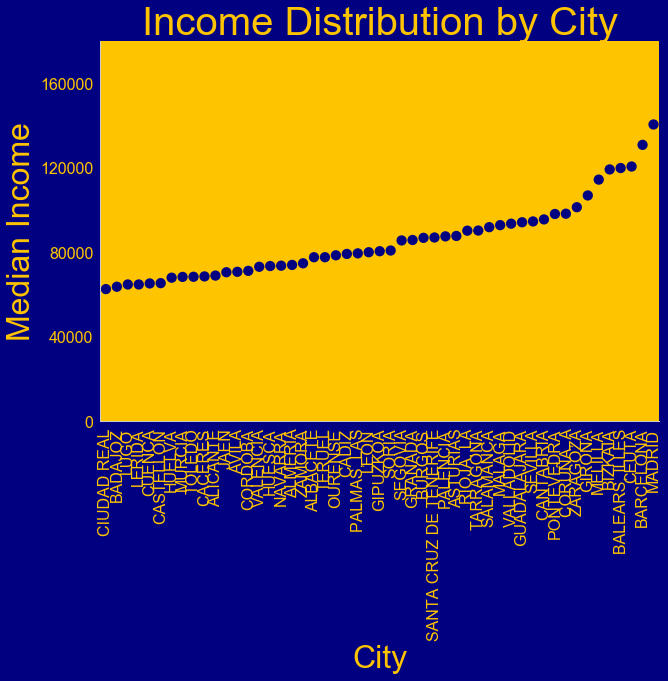

In [21]:
# Create plot to visualize income distribution by province
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "navy"}):
    h = sns.factorplot(data=incomes,
                   x="province_name",
                   y=("gross_income","MedianIncome"),
                   order=(i for i in incomes.province_name),
                   size=6,
                   aspect=1.5,
                   scale=1.0,
                   color="navy",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=16,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))



In [22]:
# Impute missing values in household income
grouped = df.groupby("province_name").agg({"gross_income":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="province_name").loc[:, ["province_name","gross_income_y"]]
new_incomes    = new_incomes.rename(columns={"gross_income_y":"gross_income"}).sort_values("gross_income")
new_incomes = new_incomes.sort_values("province_name")
df.sort_values("province_name",inplace=True)
df  = df.reset_index()
new_incomes = new_incomes.reset_index()

df.loc[df.gross_income.isnull(),"gross_income"] = new_incomes.loc[df.gross_income.isnull(),"gross_income"].reset_index()
df.loc[df.gross_income.isnull(),"gross_income"] = df.loc[df.gross_income.notnull(),"gross_income"].median()
df.sort_values(by="partition",inplace=True)

Let's now delete the redundant `province_name` variable as `province_code` is better suited for our upcoming analysis

In [23]:
df = df.drop(["province_name"], axis=1) 

In [24]:
# Customer distribution by sex (V: female; H: male)
df['gender'].value_counts()

V    563404
H    469337
Name: gender, dtype: int64

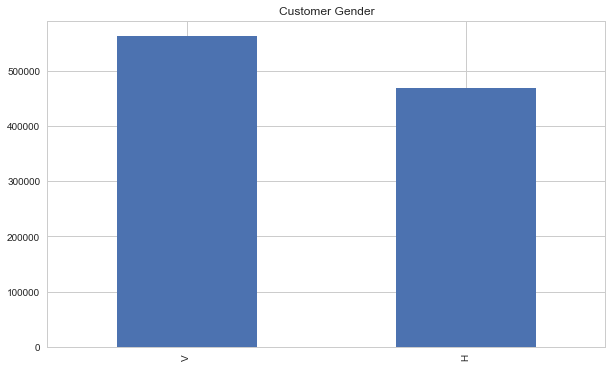

In [25]:
df["gender"].value_counts().plot(kind='bar', title = 'Customer Gender')

After checking if gender is listed in any of these customers' other rows, we arbitrarily assign them to the majority group V

In [26]:
df.loc[df['gender'].isnull(),'gender'] = 'V'

Let's now look at customer type at beginning of the month, denoted as:
```
1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)
```

In [27]:
# Customer type
df['customer_type'].value_counts()

1.0    1020848
3.0        192
2.0         62
4.0         12
Name: customer_type, dtype: int64

For now, given that the vast majority of customers are of the first/primary variety, we will designate our null customer types as first/primary customers

In [28]:
print('# of null customer types: ', df['customer_type'].isnull().sum())
df.loc[df['customer_type'].isnull(),'customer_type'] = 1.0


# of null customer types:  11637


Let's run a similar analysis of customer relation type at the beginning of the month, denoted as:
```
A (active), I (inactive), P (former customer),R (Potential)
```

In [29]:
# Updated customer type
df['customer_relation_type'].value_counts()

I    522813
A    498097
P       204
R        56
Name: customer_relation_type, dtype: int64

Let's designate our null customer relation types as inactive given the variable majority here.

In [30]:
print('# of null customer relation types: ', df['customer_relation_type'].isnull().sum())
df.loc[df['customer_relation_type'].isnull(),'customer_relation_type'] = 'I'

# of null customer relation types:  11581


In [31]:
# Updated customer relation type
df['customer_relation_type'].value_counts()

I    534394
A    498097
P       204
R        56
Name: customer_relation_type, dtype: int64

In [33]:
# Check out limited number of 'former customers'
df[df['customer_relation_type'] == 'P']

,index,partition,customer_code,employee_index,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_type,customer_relation_type,foreigner_index,join_channel,province_code,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
492761,489961,2015-01-28,634746,N,V,33.0,2006-08-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,73334.52,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
567263,553440,2015-01-28,459890,N,V,21.0,2004-02-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,225094.35,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
146257,519916,2015-01-28,862905,N,V,44.0,2010-01-27,1,0.0,1.0,3.0,P,N,NaN,8.0,1.0,131890.41,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
935779,75194,2015-01-28,1083617,N,V,24.0,2012-10-18,1,0.0,1.0,3.0,P,N,NaN,46.0,1.0,101333.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
433922,669932,2015-02-28,459890,N,V,21.0,2004-02-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,225094.35,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
483069,758051,2015-02-28,634746,N,V,33.0,2006-08-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,73334.52,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
984049,1190362,2015-02-28,1083617,N,V,24.0,2012-10-18,1,0.0,1.0,3.0,P,N,NaN,46.0,1.0,101333.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
940019,1817289,2015-03-28,1083617,N,V,24.0,2012-10-18,1,0.0,1.0,3.0,P,N,NaN,46.0,1.0,101333.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
710295,1294029,2015-03-28,459890,N,V,21.0,2004-02-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,225094.35,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
717296,1277483,2015-03-28,634746,N,V,33.0,2006-08-17,1,0.0,1.0,3.0,P,N,NaN,28.0,0.0,73334.52,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


We notice that these are the same customers are the same as those listed as 'former' customers above, which makes sense. Given the extremely small sample and the fact that we will not be predicting new products for former customers, let's go ahead and delete these rows from our dataset.

In [34]:
# Delete former customers
df = df[df["customer_relation_type"] != 'P']

After this, we are left only with first/primary customers; thus, we can exclude our 'customer type' variable in our analysis



In [35]:
df = df.drop(["customer_type"], axis=1) 

Let's look at the main channels through which customers joined Santander. This is seen in our 'join_channel' variable. We were unable to ferret out what the various join channel acronyms stood for; this is potentially by design to help Santander ensure customer anonymity.

In [36]:
# Join channel
df['join_channel'].value_counts().head(10)

KHE    338954
KAT    260435
KFC    237671
KFA     31664
KHK     18328
KHQ     11419
KHD      9865
KAS      7116
KAG      5845
RED      5534
Name: join_channel, dtype: int64

Let's take a closer look at our null values to see if we can intelligently impute these.

In [37]:
# Check out null values
df[df['join_channel'].isnull()]

,index,partition,customer_code,employee_index,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_relation_type,foreigner_index,join_channel,province_code,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
663118,342563,2015-01-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,NaN,28.0,1.0,191298.60,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
511241,447816,2015-01-28,200324,N,V,59.0,2000-10-23,0,88.0,1.0,A,N,NaN,28.0,0.0,157480.53,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
626665,579209,2015-01-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,NaN,28.0,1.0,528905.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
457312,805329,2015-02-28,200324,N,V,59.0,2000-10-23,0,88.0,1.0,A,N,NaN,28.0,0.0,157480.53,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
427129,674145,2015-02-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,NaN,28.0,1.0,528905.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
512095,910600,2015-02-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,NaN,28.0,1.0,191298.60,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
558379,1446899,2015-03-28,200324,N,V,59.0,2000-10-23,0,88.0,1.0,A,N,NaN,28.0,0.0,157480.53,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
710178,1293290,2015-03-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,NaN,28.0,1.0,528905.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
597669,1530849,2015-03-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,NaN,28.0,1.0,191298.60,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
704046,2166421,2015-04-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,NaN,28.0,1.0,191298.60,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0


We note from the dataframe displayed above that all customers with null `join_channel` values are on the older end and have been customers for a relatively long time. Let's segment our data further in hopes of gaining an idea where these customers came from:

In [38]:
df[(df['age'] > 47) & (df['customer_seniority'] > 87)]['join_channel'].value_counts().head(3)

KAT    118197
KFC     59292
KFA      9559
Name: join_channel, dtype: int64

We see that a clear majority of customers in our dataset aged > 47 and with a listed seniority > 87 joined via the 'KAT' channel. Let's lump our null values in with them as that is our best estimation of how/why they joined.



In [39]:
df.loc[df['join_channel'].isnull(),'join_channel'] = 'KAT'

Next let's look at our `segmentation` variable, which represents:
```
01 - VIP, 02 - Individuals 03 - college graduated
```

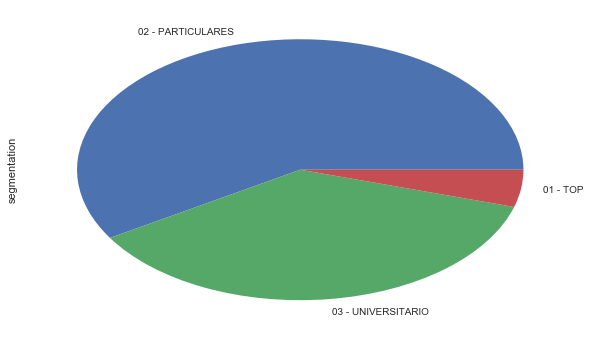

In [40]:
df['segmentation'].value_counts().plot(x=None, y=None, kind='pie')

In [41]:
# Check out null values
df[df['segmentation'].isnull()]

,index,partition,customer_code,employee_index,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_relation_type,foreigner_index,join_channel,province_code,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
663118,342563,2015-01-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,KAT,28.0,1.0,191298.60,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
515670,429735,2015-01-28,51768,N,H,77.0,2005-05-25,0,132.0,99.0,I,N,007,28.0,0.0,101333.70,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0
511241,447816,2015-01-28,200324,N,V,59.0,2000-10-23,0,88.0,1.0,A,N,KAT,28.0,0.0,157480.53,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
648266,541409,2015-01-28,808898,N,H,66.0,2008-10-24,0,16.0,99.0,I,N,RED,28.0,0.0,101333.70,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0
626665,579209,2015-01-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,KAT,28.0,1.0,528905.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
984747,204753,2015-01-28,1345889,N,H,39.0,2014-11-21,0,8.0,99.0,I,N,KHK,46.0,0.0,101333.70,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
457312,805329,2015-02-28,200324,N,V,59.0,2000-10-23,0,88.0,1.0,A,N,KAT,28.0,0.0,157480.53,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
427129,674145,2015-02-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,KAT,28.0,1.0,528905.70,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
520705,705770,2015-02-28,808898,N,H,66.0,2008-10-24,0,16.0,99.0,I,N,RED,28.0,0.0,101333.70,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0
476560,824084,2015-02-28,51768,N,H,77.0,2005-05-25,0,132.0,99.0,I,N,007,28.0,0.0,101333.70,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0


Unfortunately, we do not see any clear patterns here, so we will group them in with the majority `02 - PARTICULARES` group

In [42]:
df.loc[df['segmentation'].isnull(),'segmentation'] = '02 - PARTICULARES'

Let's now look at our last remaining null values in our `payroll` & `pensions2` variables. Given that we have the same number of null values for each, we assume they are coming from the same rows. Let's check this assumption.

In [43]:
# Check payroll nulls
df[df['payroll'].isnull()]

,index,partition,customer_code,employee_index,gender,age,customer_start_date,new_customer_index,customer_seniority,primary_customer,customer_relation_type,foreigner_index,join_channel,province_code,activity_index,gross_income,segmentation,savings_account,guarantees,current_account,derivada_account,payroll_account,junior_account,another_particular_account,particular_account,particular_plus_account,short_term_deposit,medium_term_deposit,long_term_deposit,e_account,funds,mortgage,pensions1,loans,taxes,credit_card,securities,home_account,payroll,pensions2,direct_debit
893138,493833,2015-01-28,623414,N,H,21.0,2006-06-22,0,22.0,1.0,A,N,RED,41.0,1.0,101333.70,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
663118,342563,2015-01-28,256905,N,H,70.0,2001-06-27,0,88.0,1.0,A,N,KAT,28.0,1.0,191298.60,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
252884,261049,2015-01-28,1135705,N,V,34.0,2013-05-29,0,26.0,1.0,A,N,KFC,12.0,1.0,78786.42,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
469109,470814,2015-01-28,693597,N,V,47.0,2007-05-28,1,5.0,1.0,A,N,KAT,28.0,1.0,277450.44,01 - TOP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
866203,207733,2015-01-28,1376688,N,H,34.0,2015-01-16,1,5.0,1.0,I,N,KHL,41.0,0.0,54200.70,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
626665,579209,2015-01-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,KAT,28.0,1.0,528905.70,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0
335987,291911,2015-01-28,1241619,N,H,45.0,2014-02-03,1,3.0,1.0,A,N,KHN,18.0,1.0,101333.70,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
758919,209123,2015-01-28,1374202,N,V,51.0,2015-01-05,1,4.0,1.0,I,N,KHK,30.0,1.0,27250.20,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0
163663,319028,2015-01-28,267708,N,V,46.0,2001-08-09,0,150.0,1.0,A,N,013,8.0,1.0,103531.53,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,0
427129,674145,2015-02-28,457435,N,H,57.0,2004-02-04,0,59.0,1.0,A,S,KAT,28.0,1.0,528905.70,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0


Confirmed that the null values are coming from the same rows. Apart from the null pensions/payrolls2 nulls, we notice a disproportionate number of them are new customers. This would seemingly reduce their likelihood of having either a payroll or pensions2 account open at Santander. Let's dive further into the variables before deciding how to handle these null values.

Let's look at the overall distribution of our payroll variable.

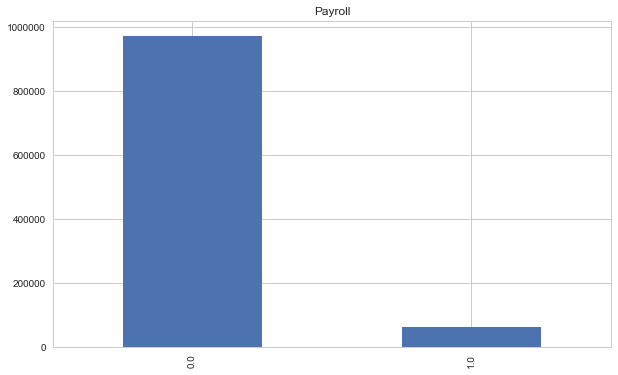

In [44]:
df['payroll'].value_counts().plot(kind='bar', title = 'Payroll')

Given the fact that the vast majority or customers do not have payroll accounts, we will assume null values of 'payroll' are 0. 

In [45]:
df.loc[df['payroll'].isnull(),'payroll'] = 0.0

Now let's look at our `pensions2` variable

In [46]:
df['pensions2'].value_counts()

0.0    965553
1.0     66962
Name: pensions2, dtype: int64

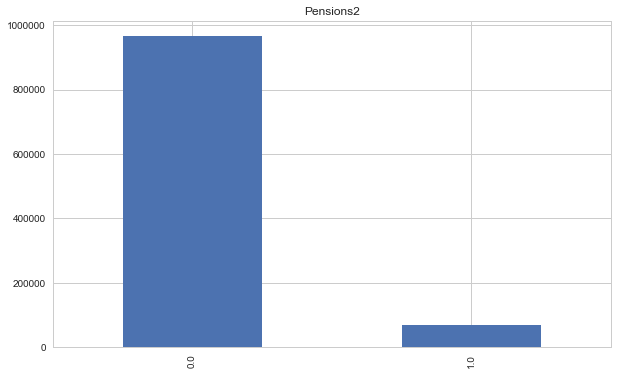

In [47]:
df['pensions2'].value_counts().plot(kind='bar', title = 'Pensions2')

Like above, let's assume all null values of 'pensions2' are 0 and move forward with our analysis

In [48]:
df.loc[df['pensions2'].isnull(),'pensions2'] = 0.0

Let's check to ensure we have no remaining null values in our dataset and move to the next phase of our analysis.

In [49]:
df.isnull().sum()

index                         0
partition                     0
customer_code                 0
employee_index                0
gender                        0
age                           0
customer_start_date           0
new_customer_index            0
customer_seniority            0
primary_customer              0
customer_relation_type        0
foreigner_index               0
join_channel                  0
province_code                 0
activity_index                0
gross_income                  0
segmentation                  0
savings_account               0
guarantees                    0
current_account               0
derivada_account              0
payroll_account               0
junior_account                0
another_particular_account    0
particular_account            0
particular_plus_account       0
short_term_deposit            0
medium_term_deposit           0
long_term_deposit             0
e_account                     0
funds                         0
mortgage

### 2.1.2 September 2015 EDA

Now that we've confirmed we have no more null values, let's segment our dataset and run some more granular EDA on the slice of data which we will be using for our churn analysis. In order to avoid serial correlation and loss of independence for our models, we will be using one slice of data from September 2015. 

In [50]:
dfpart = df[df['partition'] == '2015-09-28']

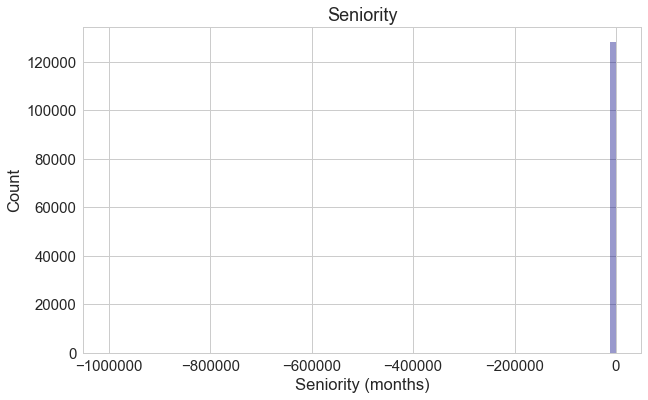

In [51]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(dfpart["customer_seniority"].dropna(),
                 bins=80,
                 kde=False,
                 color="navy")
    plt.title("Seniority")
    plt.xlabel("Seniority (months)")
    plt.ylabel("Count")

It is interesting to note the bimodal, irregular distribution of the seniority graph. We do not need this variable to be normally distributed, so for now we will just note that it has this distinctive bimodal shape.

Now let's delve deeper into our gross income variable, `gross_income`. This variable captures the *household* gross income of the customer (not just the customer themself). 

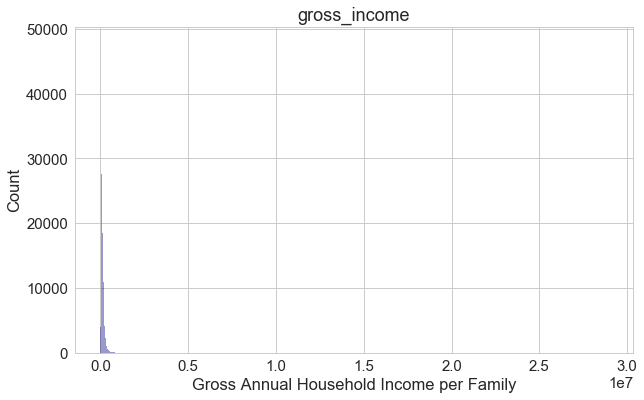

In [52]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(dfpart["gross_income"].dropna(),
                 bins=800,
                 kde=False,
                 color="navy")
    plt.title("gross_income")
    plt.xlabel("Gross Annual Household Income per Family")
    plt.ylabel("Count")

Looks like we have some extreme outliers to upside (as would be expected in any wealth distribution). Let's zoom in on household incomes [0, 1M] to see the shape for most of our data.

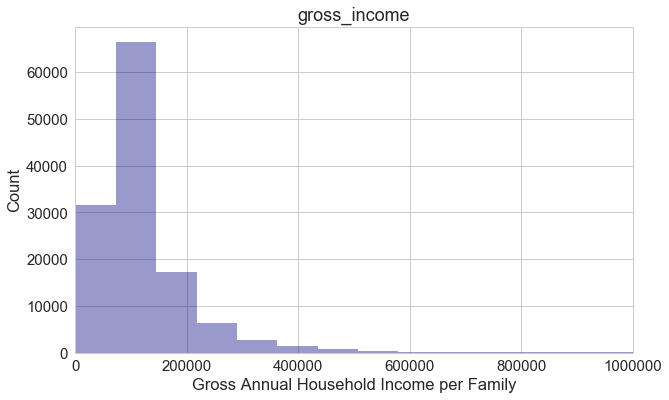

Household income mean: EUR 127,978.32
Household income median: EUR 101,333.70


In [53]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(dfpart["gross_income"].dropna(),
                 bins=400,
                 kde=False,
                 color="navy")
    plt.title("gross_income")
    plt.xlabel("Gross Annual Household Income per Family")
    plt.ylabel("Count")
    plt.xlim(0, 1000000)
    plt.show()
print('Household income mean:', 'EUR {:,.2f}'.format(df['gross_income'].mean()))
print('Household income median:', 'EUR {:,.2f}'.format(df['gross_income'].median()))

This looks much closer to what we would expect, but we do want to note that as a whole, the values seem very high. A quick Google search shows the average annual household income in Spain to be around 25k Euros per year. While it is certainly plausible that Santander customers tend to be wealthier than the average Spanish resident, a discrepancy of this magnitude seems unlikely. Another, more likely, explanation is that Santander applied some sort of scaling factor to these income numbers in order to obscure customer identities. Let's try to get a better understanding of our gross income distribution.

In [54]:
pd.options.display.float_format = '${:,.2f}'.format

# Continuing to investigate our overall household income distribution
percs = [.25, .5, .75, .9, .95, .975, .98, .99, .995, .999, .9999]
pd.DataFrame(dfpart["gross_income"].describe(percentiles = percs))

,gross_income
count,"$128,143.00"
mean,"$127,261.00"
std,"$189,979.57"
min,"$1,202.73"
25%,"$73,737.76"
50%,"$101,333.70"
75%,"$140,333.52"
90%,"$216,978.24"
95%,"$286,569.08"
97.5%,"$375,415.98"


Lastly, let's take a look at the highest 20 household incomes in our dataset to see just how large this top-end wealth disparity is:

In [55]:
dfpart.nlargest(20, 'gross_income')['gross_income']

521149   $28,894,395.51
405541   $22,034,738.76
83907    $15,711,716.46
488942   $14,337,025.92
424492   $11,411,517.27
439727   $11,411,517.27
902040   $11,341,152.48
532194   $11,139,895.56
520534   $11,139,895.56
708865   $11,139,895.56
417036    $9,792,857.49
422628    $9,659,263.86
407660    $8,325,500.79
511794    $8,325,500.79
664872    $6,147,682.02
847911    $5,431,377.63
845299    $5,431,377.63
134030    $5,364,154.08
543221    $5,046,790.47
48553     $4,950,059.34
Name: gross_income, dtype: float64

We will be cognizant of these extreme gross income values but leave them in our dataset for our analysis as they are customary to most populations.

Let's now look at our customer age distribution:

In [56]:
# Reset formatting
pd.reset_option('display')

height has been deprecated.

line_width has been deprecated, use display.width instead (currently both are
identical)



/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  


In [57]:
dfpart['age'].describe()

count    128143.000000
mean         40.046308
std          17.134208
min           2.000000
25%          24.000000
50%          39.000000
75%          50.000000
max         117.000000
Name: age, dtype: float64

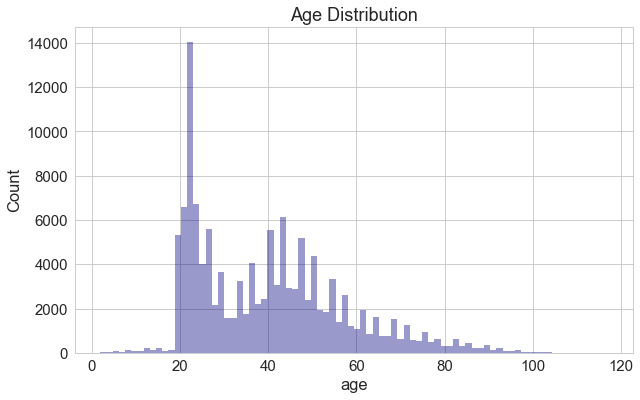

In [58]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(dfpart["age"].dropna(),
                 bins=82,
                 kde=False,
                 color="navy")
    plt.title("Age Distribution")
    plt.ylabel("Count")

Interesting to note the age distribution seems bimodal, with a disproportionate number of young adults and another peak centered around 45 years old. Let's remove outliers, which we determine to be those aged < 19 or > 100. We choose less than 19 because 

/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


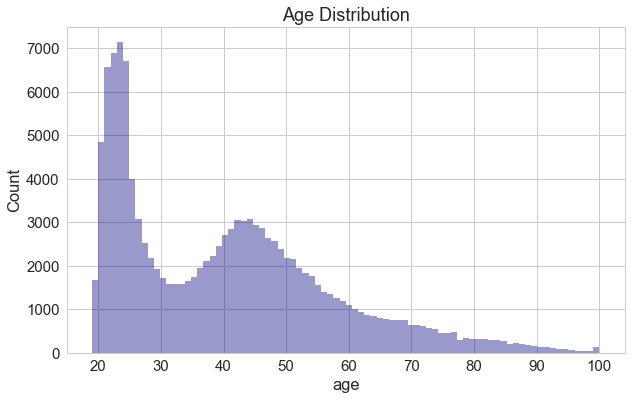

In [59]:
dfpart.loc[dfpart['age'] < 19, "age"] = 19
dfpart.loc[dfpart['age'] > 100, "age"] = 100

# Plot our modified ages
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(dfpart["age"].dropna(),
                 bins=82,
                 kde=False,
                 color="navy")
    plt.title("Age Distribution")
    plt.ylabel("Count")

Next we look at `new_customer_index`, which indicates whether or not a customer is new. We are curious to see how long they have been banking with Santander.

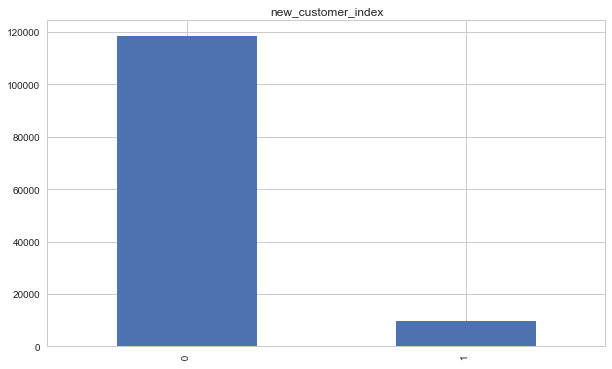

In [60]:
dfpart['new_customer_index'].value_counts().plot(kind='bar', title = 'new_customer_index')

The bulk of all customers are not surprisingly not 'new'.

Let's look at the distribution of our customer `join_channel` variable and see from which channels the customers come to do business with Santander. The simplest way to visualize this is with a pie chart. We are not sure what each of these channels means, but we clearly see that many of the customers are coming in through `KHE`, `KAT`, and `KFC` channels. 

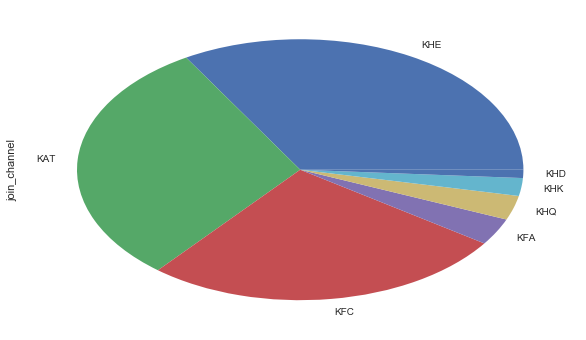

In [61]:
dfpart["join_channel"].value_counts().head(7).plot(x=None, y=None, kind='pie')

Similarily, we will inspect `employee_index`, defined by these values, 
```
A: active, B: ex-employed, F: filial, N: not employee, P: passive
```

In [62]:
dfpart['employee_index'].value_counts()

N    128068
B        29
F        24
A        22
Name: employee_index, dtype: int64

The vast majority of our data is not an employee, as indicated by `N`. This is good to note as employee status could affect which promotions (if any) an employee is eligible to get. Even if they were likely to churn, Santander may not be able to offer anything.

Next is `primary_customer`, which indicates:
```
1: (First/Primary), 99: (Primary customer during the month but not at the end of the month)
```

In [63]:
# Primary customers
dfpart['primary_customer'].value_counts()

1.0     127906
99.0       237
Name: primary_customer, dtype: int64

This variable is interesting because it's categorical in nature but is an integer value. This could prove problematic later. If we decide to use this variable in a model, we should consider recoding to string values to be treated as a factor rather than a continuous variable.

Let's look at our activity index variable, `activity_index`. As can be expected, this variable indicates whether our customers are active or inactive as denoted by the following values:
```
Activity index (1, active customer; 0, inactive customer)
```

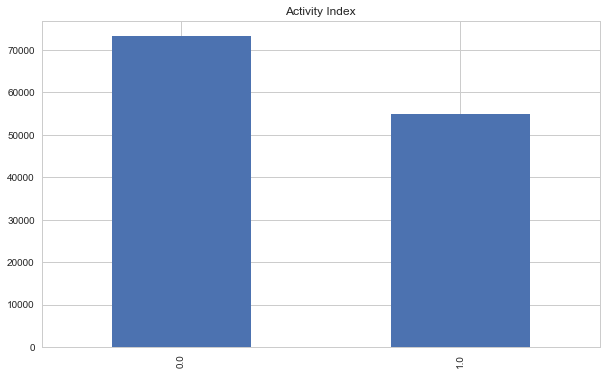

In [64]:
# Activity index
dfpart["activity_index"].value_counts().plot(kind='bar', title = 'Activity Index')

#### 2.1.2.1 Introduce products

Let's start by looking at the number of products by segment and sex

In [65]:
df_a = dfpart.loc[:, ['gender', 'foreigner_index', 'employee_index']].join(dfpart[["credit_card"]])
df_a = df_a.groupby(['gender', 'foreigner_index', 'employee_index']).sum()
df_a = df_a.T

In [66]:
df_a

gender           H                   V                 
foreigner_index  N                S  N                S
employee_index   A  B  F     N    N  A  B  F     N    N
credit_card      7  2  1  1752  116  7  2  1  3406  170

Because we will do models for credit cards, we will focus on the values for these demographics within this product. We have a pretty even split between men and women in the data, which is good because it roughly represents a broader population. In the `foreigner_index`, we see that we have a greater number of people that are not foreigners vs. foreigners.

We want to take a look at credit cards more in-depth by sex and their customer segment to gauge who the demographic using this product is. The boxplot below describes this data.

Text(0,0.5,'Product')

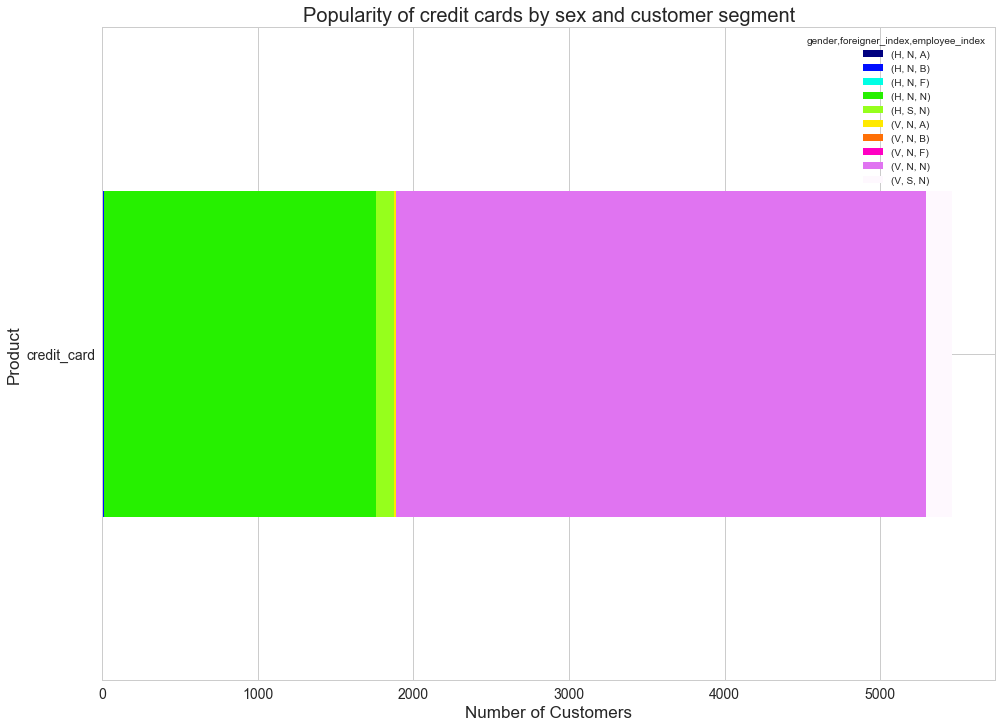

In [67]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_ncar')
plt.title('Popularity of credit cards by sex and customer segment', fontsize=20) 
plt.xlabel('Number of Customers', fontsize=17) 
plt.ylabel('Product', fontsize=17) 
# plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            # "Sex:V; Activity_Ind:1"], prop={'size':15}) 

We see the most prominent categories reflected like we saw in the tabular visual above here, as well. 

Next, we'll take a look at how many products customers have. By far, we see the majority of customers with a total products of 0, which is interesting because we wonder what these customers are doing in the dataset if they have no products. Nonetheless, we will not worry about them because only those with a credit card/ direct deposit in either September 2015 or August 2015 will be included in our model dataset. 

In [68]:
# Add a new column of the total number of products per customer per month
df["tot_products"] = df.loc[:,"credit_card": "direct_debit"].sum(axis=1)
df["tot_products"] = pd.to_numeric(df["tot_products"], errors="coerce") 

# Total number of products per customer
df["tot_products"].value_counts()


0.0    845906
1.0     99710
3.0     31660
2.0     31055
4.0     20834
5.0      3311
6.0        71
Name: tot_products, dtype: int64

Lastly, we want to see what ages the customers with the most product utilization are. We look at the top ten to see and note that we have customers in their early 20s and in their 40s. It will be interesting to see the relationship between age and churn in our models.

In [69]:
# Let's segment total products by age
df.groupby(['age'])['tot_products'].agg('sum').sort_values(ascending=False).head(10)

age
45.0    16308.0
44.0    15946.0
43.0    14992.0
42.0    14807.0
47.0    14546.0
46.0    14071.0
48.0    13857.0
41.0    12733.0
49.0    12097.0
40.0    11818.0
Name: tot_products, dtype: float64

In [70]:
df['employee_index'] = df['employee_index'].astype('category').cat.codes
df['gender'] = df['gender'].astype('category').cat.codes
df['new_customer_index'] = df['new_customer_index'].astype('category').cat.codes
df['customer_relation_type'] = df['customer_relation_type'].astype('category').cat.codes
df['foreigner_index'] = df['foreigner_index'].astype('category').cat.codes
df['join_channel'] = df['join_channel'].astype('category').cat.codes
df['segmentation'] = df['segmentation'].astype('category').cat.codes

df.dtypes




index                                  int64
partition                     datetime64[ns]
customer_code                          int64
employee_index                          int8
gender                                  int8
age                                  float64
customer_start_date           datetime64[ns]
new_customer_index                      int8
customer_seniority                   float64
primary_customer                     float64
customer_relation_type                  int8
foreigner_index                         int8
join_channel                           int16
province_code                        float64
activity_index                       float64
gross_income                         float64
segmentation                            int8
savings_account                        int64
guarantees                             int64
current_account                        int64
derivada_account                       int64
payroll_account                        int64
junior_acc

## 2.2 Credit Card Modeling

As mentioned above, we picked one month of data to study. We selected a month with one of the greatest number of credit card customers and calculated which credit card customers from the prior month did not use a credit card product that month. The month chosen is September 2015 with the prior month being August 2015. 

With that information, we derived a new column called "churn" with two values: 0 and 1. The value of zero (0) indicates that they did not churn (i.e. they had a credit card product that month) and a value of one (1) indicates that they did churn from the prior month. The code to do this is below. 

### 2.2.1 Data Transformation

The code below shows us how many unique customers are recorded in a given month and how many utilized credit card products. 

In [71]:
print(df.groupby("partition").agg({"customer_code": pd.Series.nunique, "credit_card":np.sum}))


            customer_code  credit_card
partition                             
2015-01-28          91589         5404
2015-02-28          92030         5198
2015-03-28          92397         5286
2015-04-28          92706         5458
2015-05-28          93022         5447
2015-06-28          93294         5530
2015-07-28         122843         5606
2015-08-28         124797         5547
2015-09-28         128143         5464
2015-10-28         101726         3930


In [72]:
df_backup = df

In [73]:
df["partition"] = pd.to_datetime(df["partition"],format="%Y-%m-%d")
df["customer_start_date"] = pd.to_datetime(df["customer_start_date"],format="%Y-%m-%d")

In [74]:

# Calculate which customers in August 2015 had credit cards
# Create a dataframe with those customer codes & write into a list
df_aug_customer = pd.DataFrame(df[(df['partition'] == '2015-08-28') & (df['credit_card']==1)]['customer_code'])
customers_in_aug = df_aug_customer['customer_code'].tolist()

# Calculate which customers in September 2015 had credit cards
df_sep = df[((df['partition'] == '2015-09-28') & (df['credit_card']==1))]
# Set the column churn equal to 0
df_sep['churn'] = 0
# Write the September customers into a list
customers_in_sep = df_sep['customer_code'].tolist()

# Calculate which customers are not September credit card customers but 
# are in August. Get the data for those customers in September (what is their crieteria when churn)
# Set column churn equal to 1
df_churn = df[((df['partition'] == '2015-09-28') & (df['credit_card']==0) & (df['customer_code'].isin(customers_in_aug)))]
df_churn['churn'] = 1

# Combine dataframes to make 1 dataframe with all customers that
# had a credit card in September or churned in September. 
frames = [df_sep, df_churn]
df_final_all = pd.concat(frames)
df_final_label = df_final_all.loc[:, df_final_all.columns == 'churn']
df_final = df_final_all.loc[:, df_final_all.columns != 'churn']

/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathrynpapandrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We have four columns in the explanatory variables that are not necessary for the model: `partition, index, customer_start_date`,`deceased_index, credit_card, new_customer_index, guarantees, junior_account, tot_products`. The reasons are as follows:

* We drop the `partition` and `index` because those are irrelevant for determining churn. 
* We drop `customer_start_date` because logistic models cannot handle the date/time type and `customer_seniority` describes this data, as well. Same goes for `new_customer_index`, the `customer_seniority` value describes this data. 
* We drop `deceased_index` because all values are "N" (seen below)
* `credit_card` because churn already describes this. 
* `guarantees, junior_account` because there is only one unique value for each 0
* `tot_products` because this value makes others a linear combination. We need to drop this in order for our model to converge

In [75]:
df_final_xg = df_final
df_final_lg = df_final

# Drop columns
df_final_lg = df_final_lg.drop(["partition", "index", "customer_start_date",  
                          "credit_card", "customer_code", "new_customer_index", "guarantees",
                         "junior_account", "tot_products"], axis=1) 

df_final_xg = df_final_xg.drop(["partition", "index", "customer_start_date",  
                          "credit_card", "customer_code", "new_customer_index", "guarantees",
                         "junior_account"], axis=1) 



Next, we subset this data into training and test data using the code below. All of our models will use the same training and test data split for comparable analysis. 

In [123]:
# Split into x train & test (explanatory), y train & test (outcome)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df_final_lg, df_final_label, test_size=0.2, random_state=42)

# Confirm the shapes look appropriate
print(shape(X_train_log))
print(shape(X_test_log))
print(shape(y_train_log))
print(shape(y_test_log))


(4969, 33)
(1243, 33)
(4969, 1)
(1243, 1)


### 2.2.2 Logistic Regression

The first model we start with is logistic regression. This model seems appropriate because we have an outcome variable that is binary (0, 1). In this case "success" (i.e. value of 1) is defined as churn, while "failure" (i.e. value of 0) is defined as having the credit card product.

In order to use this model, we need to first assert the assumptions of the binomial distribution:

1.*There are n identical trials*: we confirm this assumption by saying that we have 6144 identical trials (customers) that do not differ based on exogenous factors.
2. *There are two possible outcomes*: our outcome variable, `churn`, has two values: 0 or 1. 
3. *The trials are independent of each other*: we have unique customers for one time frame, so we do not have any serial correlation issues associated with panel and time series data. We are focusing on one slice of time with unique, independent customers. 
4. *The probability of success remains constant for all trials*: We assume that each customer needs a credit card equally. The only question here is whether they will pick Santander and therefore the probability of success remains constant. 

Next, we confirm the assumptions of a linear regression model:

1. *Binomial Dependent Variable*: the outcome variable is the number of churns for that customer.
2. *Observations independent of each other*: As mentioned above, each observation is a different customer in the same period of time. We have no issues with serial correlation in this data because of the time and customer slicing.
3. *No perfect collinearity*: this assumption will be confirmed below after the model is run with a Variance Inflation Factor (VIF) test. 

With our training data, we will determine which features are worth keeping by running a Recursive Feature Elimination (RFE). We do this because we want to identify which features are significant to keep in our model given the other variables are in the model, as well. This takes a lot of the guesswork out of picking statistically significant factors for our model. 

In [124]:
# Get column list
data_final_vars=df_final_lg.columns.values.tolist()
# Get feature label list & observation list
y=df_final_label
X=[i for i in data_final_vars if i not in y]

# Define logistic regression model
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train_log, y_train_log.values.ravel())

Now that we have the RFE columns identified, we will subset the data to only have the columns identified. Below is the code to have only those columns.

In [125]:
cols = []
index = 0
for i in rfe.support_:
    if i == True:
        cols.append(data_final_vars[index])
    index += 1

X=X_train_log[cols]
y=y_train_log['churn']

X_t_log = X_test[cols]
y_t_log = y_test['churn']

We fit the logistic regression model with the RFE columns as our explanatory variables only because the logit function does not converge with all variables. As a reminder, the explanatory variables we are left with are below:


In [101]:
print(cols)

['employee_index', 'primary_customer', 'customer_relation_type', 'foreigner_index', 'activity_index', 'current_account', 'derivada_account', 'payroll_account', 'another_particular_account', 'particular_account', 'short_term_deposit', 'medium_term_deposit', 'e_account', 'funds', 'mortgage', 'pensions1', 'securities', 'home_account', 'pensions2', 'direct_debit']


In [126]:
# Fit logistic regression model with all features
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict against test data
y_pred_log = pd.DataFrame(logreg.predict(X_t_log))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_t_log, y_t_log)))

Accuracy of logistic regression classifier on test set: 0.88


### 2.2.3 Ensemble Model - XGBoost Decision Tree

Now that we tried with a base model using logistic regression , we wanted to take an ensemble approach using XGBoost. This model has been very popular nowadays in any ML hackathons due to it's consistent accuracy and the speed. It proves the point that it is better to rely on the power of multiple learners. 

XGBoost is a boosting technique in which each tree is built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. Each tree learns from the predecessors and updates the residual errors. Basically , each new iteration tries to learn from the residuals from the previous iteration and minimize the residuals continously.

This model uses the same target variable "churn" as in the previous model. (In this case "success" (i.e. value of 1) is defined as churn, while "failure" (i.e. value of 0) is defined as having the credit card product.)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df_final_xg, df_final_label, test_size=0.2, random_state=42)

In [82]:
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('Accuracy of XGBoost classifier on test set: %.2f%%' % (accuracy * 100.0))

Accuracy of XGBoost classifier on test set: 99.20%


We are getting slighly better accuracy with the ensemble model and we could also take a look at the F1 score to check the feature importance as below. It appears that features such as tot_products , direct_debit, particular_account , e_account , payroll and currecnt_account have the highest influence and activity_index, mortgage , gender and join_channel have the lowest influence on the prediction. One option is to drop the features that have the lowest influence to see if that improves the performance of the model.

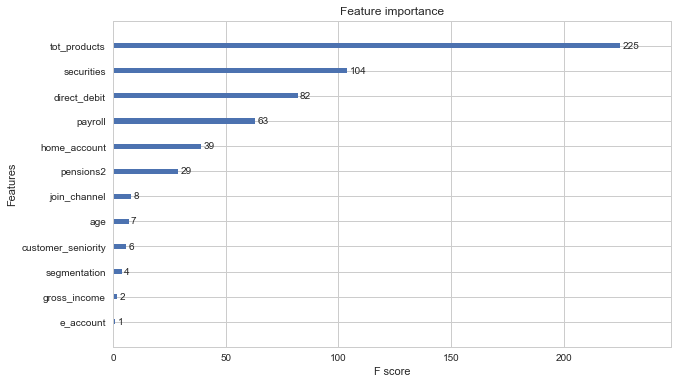

In [83]:
from xgboost import plot_importance
plot_importance(model)

### 2.2.4 Gaussian Mixture Model with PCA 

In addition to logistic regression and the decision tree models above, we also conducted a gaussian mixture model which is included below in `3.0 Analyses` section as the analysis and modeling is very much intertwined.

# 3.0 Analyses

## 3.1 Logistic Regression Output Analysis

#### 3.1.1 Confusion Matrix
Now that we have the model, we want to see where it's getting most confused between predictions and true labels. 

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_log, y_pred_log)
print(confusion_matrix)

[[1089    1]
 [ 146    7]]


This is telling us that we have 1096 correct predictions and 147 incorrect predictions.

### 3.1.2 Classification Report

Next, we want to see the classification report to gauge precision, recall and the f1-score:

In [128]:
print(classification_report(y_test_log, y_pred_log))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      1090
          1       0.88      0.05      0.09       153

avg / total       0.88      0.88      0.83      1243



The equation for f1-score is:  $\frac{2*(Recall * Precision)}{(Recall + Precision)}$

In this case, the f1-score is .83, which is pretty good for our purposes. We note that there is a stark contrast between precision, recall and f1-score between 0 and 1, though. We see that there are a lot of false positive for recall for the outcome variable = 1. This could prove costly to Santander to be trying to give out promotions to customers which are not actually at risk of churning. We will discuss this further in the analysis.

### 3.1.3 Receiver Operating Characteristic

This Receiver Operating Characteristic (ROC) grid shows us how our classification compares to a truly random classifier. In the best situations, the curve would be as far to the upper left as possible in the true positives. We, however, see here that ours is slightly higher in the true positive rate but is closer to the random curve. This insight will be taken into account with our next model: decision tree using xgboost.

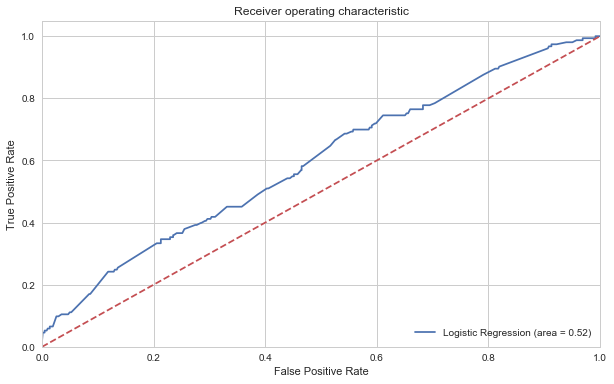

In [86]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_t))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_t)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## 3.2 XGBoost - Decision Tree Analysis

### 3.2.1 Classification Error and Log Loss curves

Log loss - short for logarithmic loss, it is a loss function for classfication that quantifies the accuracy of the a classifier by penalizing false classifications. Classification Error basically reports that how much of the dataset classified incorrectly at each epoch level as shown in the below diagrams.

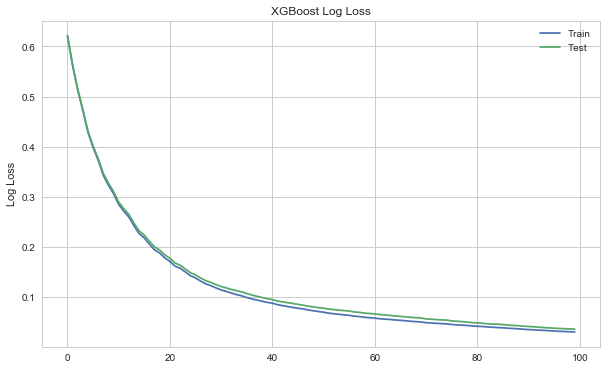

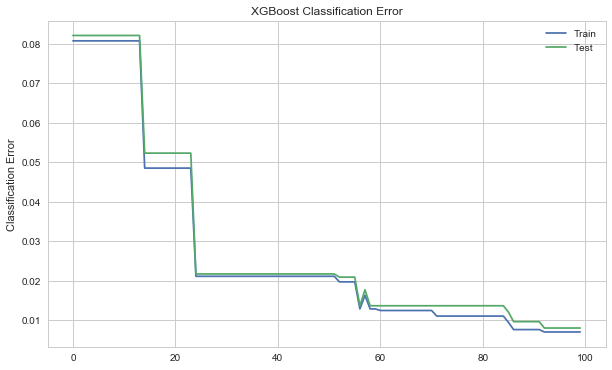

In [87]:
from matplotlib import pyplot
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

By reviewing logloss chart , it looks like there is an opportunity to stop learning early somewhere around 20 to 40. Similarly we could see that there is not much reduction in the error after epoch around 50. Making this adjustment to limit the learning between 50 and 60 will avoid the overfitting the model to the dataset we have.

### 3.2.2 Optimum max_depth and learning_rate

Though there are number of hyper parameters that can be tuned in XGBoost , we will take a look at the couple of key parameters which are super important in improving the accuracy of the model. They are `max_depth` and `learning_rate`. `max_depth` defines maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. `learning_rate` is the rate at which gradient boosted tree decision trees learns between each iteration.

,test_error,train_error
max_depth,,
3,0.052293,0.048501
6,0.012068,0.007044
9,0.003218,0.002012
12,0.003218,0.002012
15,0.003218,0.002012
30,0.003218,0.002012


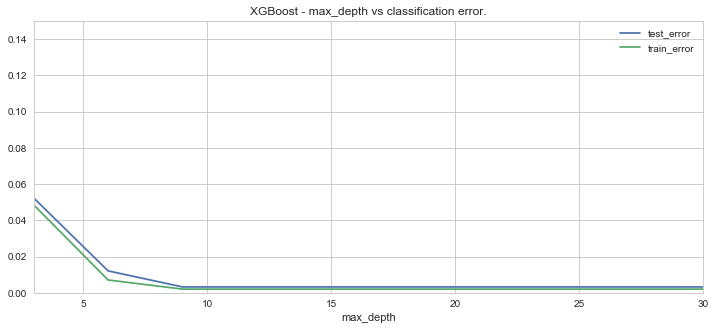

In [88]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

results = []

for max_depth in [3,6,9,12,15,30]:
    model = XGBClassifier(max_depth = max_depth,n_estimators=20)
    model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': 1 - accuracy_score(y_train, model.predict(X_train)),
            'test_error': 1 - accuracy_score(y_test, model.predict(X_test)),

        }
    )


df_max_depth = pd.DataFrame(results).set_index('max_depth').sort_index()
df_max_depth.plot(ylim = (0,0.15),figsize=(12,5),title='XGBoost - max_depth vs classification error.')
df_max_depth

By looking at this chart above , it appears that the error for both test and train data doesnt seem to be drastically reducing after the tree depth 10. Restricting to this level will avoid overfitting. Now let's take a look at the learning rate below.

,test_error,train_error
learning_rate,,
0.05,0.082060,0.080700
0.10,0.052293,0.048501
0.20,0.021722,0.021131
0.40,0.008045,0.006842
0.60,0.003218,0.002415
0.80,0.003218,0.000402
1.00,0.002414,0.000000
1.20,0.002414,0.000000
1.40,0.003218,0.000000


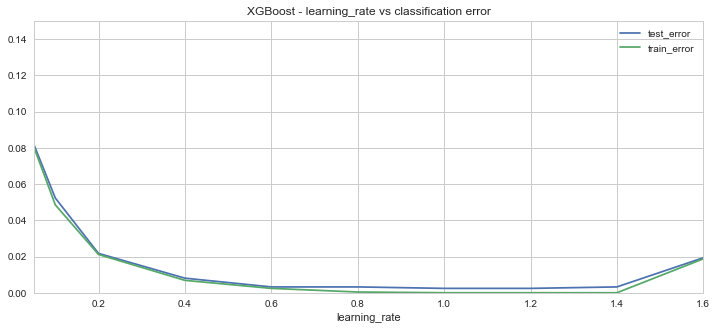

In [89]:
results = []

for learning_rate in [0.05,0.1,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6]:
    model = XGBClassifier(learning_rate = learning_rate,n_estimators=20)
    model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': 1 - accuracy_score(y_train, model.predict(X_train)),
            'test_error': 1 - accuracy_score(y_test, model.predict(X_test)),

        }
    )


df_max_depth = pd.DataFrame(results).set_index('learning_rate').sort_index()
df_max_depth.plot(ylim = (0,0.15),figsize=(12,5),title='XGBoost - learning_rate vs classification error')
df_max_depth

By reviewing the chart above , it seems that any learning rate above 1.2 seem to increase the error , so restricting the learning rate to 1.2 would improve the accuracy.

In [90]:
model = XGBClassifier(max_depth = 10, learning_rate = 1.2)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.76%


We could see the drastic improvement in the accuracy after tuning the couple of key hyper parameters in the model.

## 3.3 Gaussian Mixture Model using PCA output Analysis

In [91]:
xt = df_final
xt.columns.values

array(['index', 'partition', 'customer_code', 'employee_index', 'gender',
       'age', 'customer_start_date', 'new_customer_index',
       'customer_seniority', 'primary_customer', 'customer_relation_type',
       'foreigner_index', 'join_channel', 'province_code',
       'activity_index', 'gross_income', 'segmentation',
       'savings_account', 'guarantees', 'current_account',
       'derivada_account', 'payroll_account', 'junior_account',
       'another_particular_account', 'particular_account',
       'particular_plus_account', 'short_term_deposit',
       'medium_term_deposit', 'long_term_deposit', 'e_account', 'funds',
       'mortgage', 'pensions1', 'loans', 'taxes', 'credit_card',
       'securities', 'home_account', 'payroll', 'pensions2',
       'direct_debit', 'tot_products'], dtype=object)

In [92]:
def age_bucket(x):
    if x < 32.5:
        return 'Adolescent'
    elif x < 54.5:
        return 'Adult'
    else:
        return 'Elder'

def cs_bucket(x):
    if x < 50.5:
        return 'Recent_customer'
    elif x < 150.5:
        return 'Middling_customer'
    else:
        return 'Old_customer'
    
def gi_bucket(x):
    if x < 80000:
        return 'Low_income'
    elif x < 160000:
        return 'Middling_income'
    else:
        return 'High_income'

xt['age_bucket'] = xt.apply(lambda row: age_bucket(row['age']), axis=1)
xt['cs_bucket'] = xt.apply(lambda row: cs_bucket(row['customer_seniority']), axis=1)
xt['gi_bucket'] = xt.apply(lambda row: gi_bucket(row['gross_income']), axis=1)

We need to either standardize or one-hot encode our data before running PCA. We choose to bucket and subsequently binarize our age, customer_seniority, and gross_income.

In [93]:
# One-hot encoding
cat_vars=['gender', 'employee_index', 'new_customer_index', 'primary_customer', 'customer_relation_type', 'foreigner_index', 'join_channel', 'province_code', 'activity_index', 'segmentation', 'age_bucket', 'cs_bucket', 'gi_bucket']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(xt[var], prefix=var)
    data1=xt.join(cat_list)
    xt=data1
cat_vars=['gender', 'employee_index', 'new_customer_index', 'primary_customer', 'customer_relation_type', 'foreigner_index', 'join_channel', 'province_code', 'activity_index', 'segmentation', 'age_bucket', 'cs_bucket', 'gi_bucket']
data_vars=xt.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [94]:
pca_data_final = xt[to_keep]
# Drop superfluous vars as we did above
pca_data_final = pca_data_final.drop(['index', 'tot_products', 'partition', 'customer_code', 'customer_start_date', 'credit_card', 'age', 'gross_income', 'customer_seniority'], axis = 1)
pca_data_final.columns.values

array(['savings_account', 'guarantees', 'current_account',
       'derivada_account', 'payroll_account', 'junior_account',
       'another_particular_account', 'particular_account',
       'particular_plus_account', 'short_term_deposit',
       'medium_term_deposit', 'long_term_deposit', 'e_account', 'funds',
       'mortgage', 'pensions1', 'loans', 'taxes', 'securities',
       'home_account', 'payroll', 'pensions2', 'direct_debit', 'gender_0',
       'gender_1', 'employee_index_0', 'employee_index_1',
       'employee_index_2', 'employee_index_3', 'new_customer_index_0',
       'new_customer_index_1', 'primary_customer_1.0',
       'customer_relation_type_0', 'customer_relation_type_1',
       'foreigner_index_0', 'foreigner_index_1', 'join_channel_0',
       'join_channel_1', 'join_channel_2', 'join_channel_3',
       'join_channel_4', 'join_channel_5', 'join_channel_6',
       'join_channel_7', 'join_channel_8', 'join_channel_9',
       'join_channel_10', 'join_channel_11', 'join_c

In [95]:
# Split into train and test data.
pca_train_data, pca_train_labels = pca_data_final, df_final_label

#Split Training and Testing Dataset
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_train_data, pca_train_labels, test_size=0.2, random_state=42)
pca_y_test.shape

(1243, 1)

This leaves us with 200 binary features. We will run PCA to reduce the dimensionality from 200 down to 2 so that we can visualize the data. 

The first projected dimension is the linear combination of all 200 original features which captures as much of the variance in the data as possible. The second projected dimension is the linear combination of the 200 original features that captures as much of the remaining variance as possible. The idea is to densely represent our data in low dimensions in order to get a better understanding of our customers who churn.

,Principal Components,% of training variance explained
0,1.0,0.134968
1,2.0,0.092474
2,3.0,0.074124
3,4.0,0.063836
4,5.0,0.059307
5,6.0,0.051872
6,7.0,0.046958
7,8.0,0.044389
8,9.0,0.037043
9,10.0,0.035566


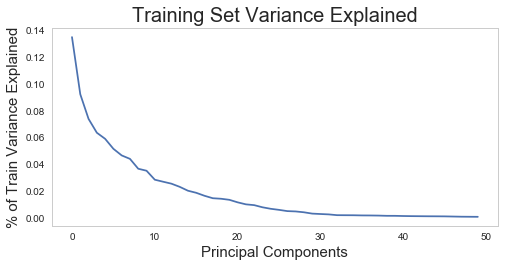

In [96]:
from sklearn.decomposition import PCA

def PCA1():
    # Set number of principal components
    n_comp = 50
    
    # PCA Projection
    pca_1 = PCA(n_components = n_comp)
    pca_1.fit(pca_X_train)
    
    # Plot % of training set variance explained
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(2,1,2) 
    plt.plot(pca_1.explained_variance_ratio_)
    ax.set_xlabel('Principal Components', fontsize = 15)
    ax.set_ylabel('% of Train Variance Explained', fontsize = 15)
    ax.set_title('Training Set Variance Explained', fontsize = 20)
    ax.grid()

    principalDf = pd.DataFrame(data = np.array([range(1, n_comp + 1), pca_1.explained_variance_ratio_]).T,
                                       columns = ['Principal Components', '% of training variance explained']) 
    return principalDf.head(10)
    
PCA1()

Below is a visualization of our training data in two dimensions. The positive (churn) cases are shown in blue and the negative (no churn) in red.

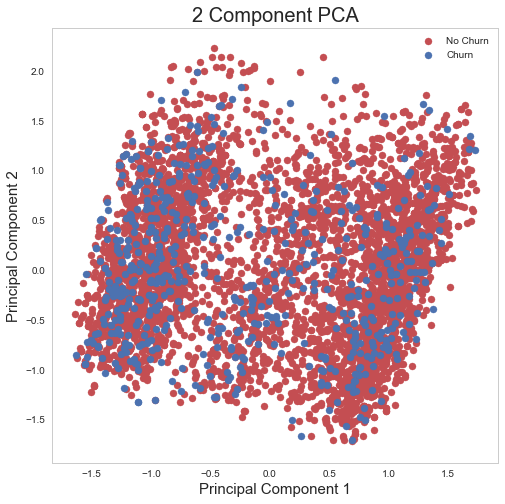

In [97]:
def PCA2():
    # Set number of principal components
    n_comp = 2
    
    # PCA Projection
    pca_2 = PCA(n_components = n_comp)
    principalComponents = pca_2.fit_transform(pca_X_train)
    principalDF = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    finalDF = pd.concat([principalDF, pd.DataFrame(data = pca_y_train).reset_index(drop = True)], axis = 1)
    
    # Plot results
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDF['churn'] == target
        ax.scatter(finalDF.loc[indicesToKeep, 'principal component 1']
                   , finalDF.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(['No Churn', 'Churn'])
    ax.grid()

PCA2()

KMeans with [1,24] clusters over the two-dimensional data projections. Each cluster's centroid is marked and a circle is drawn around the most distant point assigned to each cluster.

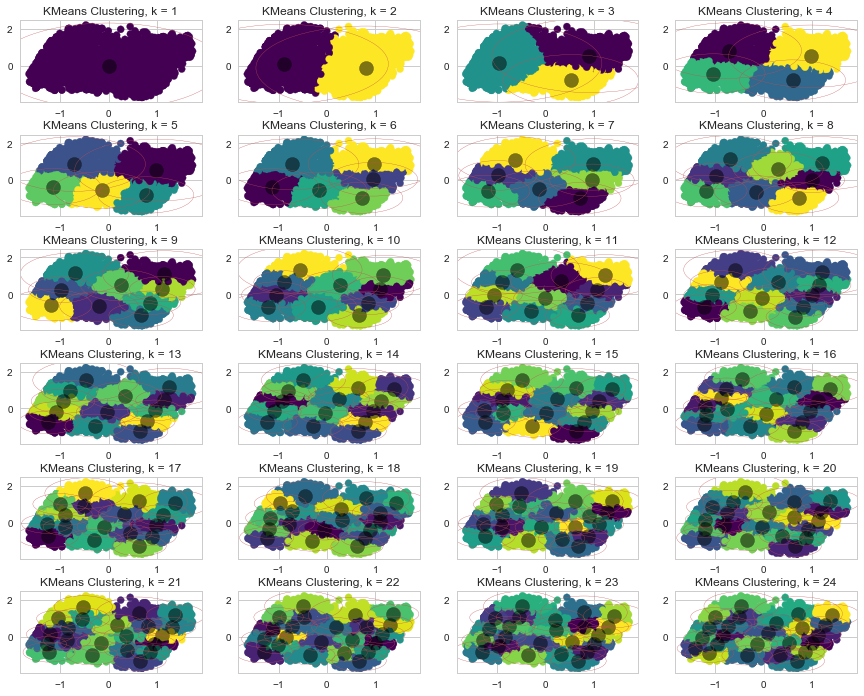

In [98]:
from sklearn.cluster import KMeans

def PCA3():
    
    # Set number of principal components
    n_comp = 2

    # PCA Projection
    pca_3 = PCA(n_components = n_comp)
    PC = pca_3.fit_transform(pca_X_train)

    # Determine # of clusters to iterate over
    clusters = 24
    fig = plt.figure(figsize = [15,12])
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    for k in range(1, clusters + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(PC)
        y_kmeans = kmeans.predict(PC)
        
        ax = fig.add_subplot(6, 4, k)
        
        plt.scatter(PC[:, 0], PC[:, 1], c=y_kmeans, s=50, cmap='viridis')
        plt.title('KMeans Clustering, k = {}'.format(k))

        # Mark each centroid cluster
        centers = kmeans.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

        # Plot a circle that goes through the most distant point assigned to each cluster
        # Note that 'circles' may appear lobsided due to plot dimensions
        distances = np.zeros((PC.shape[0],2))
        for i in range(PC.shape[0]):
            distances[i][0] = np.sqrt((PC[i][0]-centers[kmeans.labels_[i]][0])**2+(PC[i][1]-centers[kmeans.labels_[i]][1])**2)
            distances[i][1] = kmeans.labels_[i]
        df = pd.DataFrame(data=distances, columns = ['distance', 'label'])
        radii = df.groupby('label')['distance'].max()
        for r in range(k):
            ax.add_artist(plt.Circle((centers[r]), radii[r], color='r', fill = False))

PCA3()  

Below we fit a Gaussian Mixture model to the positive (churn) examples in our two-dimensional projected data. We then plot the estimated density contours while varying the number of mixture components and covariance matrix type.

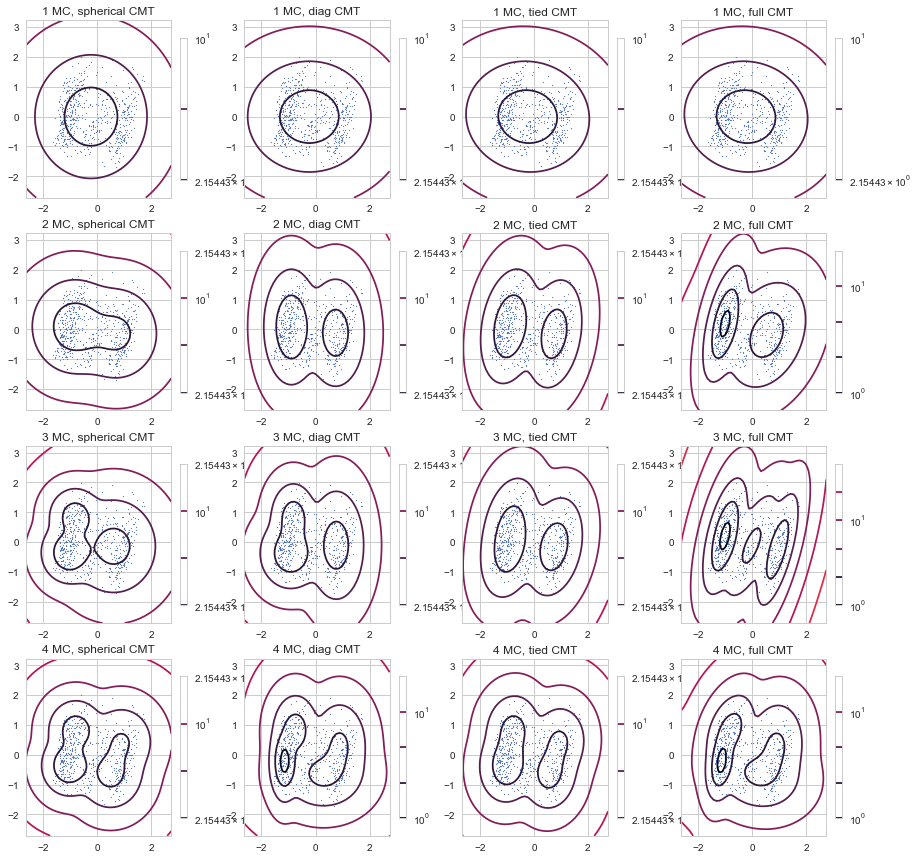

In [99]:
from sklearn import mixture
from matplotlib.colors import LogNorm

def PCA4():
    # Set number of principal components
    n_comp = 2

    # PCA Projection
    pca_4 = PCA(n_components = n_comp)
    PC4 = pca_4.fit_transform(pca_X_train)
    
    # Select only positive examples
    PC4_DF = pd.DataFrame(data = PC4
             , columns = ['pc1', 'pc2'])
    DF4 = pd.concat([PC4_DF, pd.DataFrame(data = pca_y_train).reset_index(drop = True)], axis = 1)
    DF4_final_pos = DF4[DF4['churn'] == 1][['pc1','pc2']]

    mixture_components = 4
    cov_matrix_type = ['spherical', 'diag', 'tied', 'full']
    plt.figure(figsize = (15, 15))
    i = 1
    for mc in range(1, mixture_components + 1):
        for cmt in cov_matrix_type:
            clf = mixture.GaussianMixture(n_components = mc, covariance_type = cmt)
            clf.fit(DF4_final_pos)

            # display predicted scores by the model as a contour plot
            x = np.linspace(np.min(PC4[:, 0]) - 1, np.max(PC4[:, 0]) + 1)
            y = np.linspace(np.min(PC4[:, 1]) - 1, np.max(PC4[:, 1]) + 1)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T

            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)
                        
            plt.subplot(4,4, i)
            i += 1
            # ax = plt.subplot2grid((4,4), (counterx, countery))
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(DF4_final_pos['pc1'], DF4_final_pos['pc2'], s = .8)
            
            plt.title('{} MC, {} CMT'.format(mc, cmt))
            plt.axis('tight')

PCA4()




Here we try to use our GMM to make predictions on our test set. We find that the results are not great, especially considering that a naive model which predicts no churn 100% of the time will be have an "accuracy" of ~90%.

In [100]:
def PCA5():
    # Set number of principal components
    n_comp = 2

    # PCA Projection
    pca_5 = PCA(n_components = n_comp)
    PC5 = pca_5.fit_transform(pca_X_train)

    # Project test data in two dimensions
    PCA_test_data = pca_5.fit_transform(pca_X_test)

    # Partition into +/- examples
    PC5_DF = pd.DataFrame(data = PC5
             , columns = ['pc1', 'pc2'])
    DF5 = pd.concat([PC5_DF, pd.DataFrame(data = pca_y_train).reset_index(drop = True)], axis = 1)
    DF5_final_pos = DF5[DF5['churn'] == 1][['pc1','pc2']]
    DF5_final_neg = DF5[DF5['churn'] == 0][['pc1','pc2']]

    cov_matrix_type = ['spherical', 'diag', 'tied', 'full']
    number_components = 10
    # Initialize 
    best = 0
    for cmt in cov_matrix_type:
        for c in range(1,number_components):
            # Fit 4-component full covariance GMMs on positive examples in our 2d projected data
            clf5_pos = mixture.GaussianMixture(n_components = c, covariance_type = cmt, random_state = 0, n_init = 5)
            clf5_pos.fit(DF5_final_pos)

            # Fit 4-component full covariance GMMs on negative examples in our 2d projected data
            clf5_neg = mixture.GaussianMixture(n_components = c, covariance_type = cmt, random_state = 0, n_init = 5)
            clf5_neg.fit(DF5_final_neg)

            # Initialize arrays of likelihoods & test set predictions 
            test_label_preds = np.zeros(pca_y_test.shape)

            for counter, ex in enumerate(PCA_test_data):
                # Compute label probabilities
                pos_score = clf5_pos.score([ex])
                neg_score = clf5_neg.score([ex])
                # Change test set prediction to '1' if prob(churn) > prob(not churn)
                if pos_score > neg_score:
                    test_label_preds[counter] = 1
            correct_preds = np.sum(test_label_preds == pca_y_test)[0]
            test_accuracy = correct_preds / pca_y_test.shape[0]
            if test_accuracy > best:
                best = test_accuracy
                print('Test accuracy with {} component(s), {} covariance type: {:.2%}'.format(c, cmt, test_accuracy))
PCA5()




Test accuracy with 1 component(s), spherical covariance type: 52.61%
Test accuracy with 2 component(s), spherical covariance type: 54.87%
Test accuracy with 5 component(s), spherical covariance type: 60.26%
Test accuracy with 6 component(s), spherical covariance type: 63.23%


# 4.0 Conclusions

Our goal was to provide Santander Bank with the analysis and tools necessary to proactively decrease credit card customer churn seen at the company. Keeping existing customers is always significantly less expensive than recruiting new ones and is paramount to building and maintaining a successful company.

Our first step in this process was to conduct an exploratory data analysis on the glut of information Santander provided us. We scrubbed the data, removing and imputing null values as necessary, until we were convinced what remained was an accurate,thorough, and interpretable dataset. We then conducted a number of different analyes with varying degrees of success. We found that a logistic regression was able to predict customer credit card churn with 88% accuracy but did not perform much better than a completely naive model once we dug into the output. We also tried running principal component analysis in an attempt to decrease the dimensionality of and better visualize our data, but saw that the accuracy was not as good as our final model and the interpretability became more opaque.

Our final recommendation stems from our XGBoost analysis. We were able to predict customer churn on our test set with an accuracy of greater than 99% with this gradient boosting algorithm, even when taking overfitting into account by tuning our hyperparameters. This, of course, is a very appealing option. 

We thus recommend that Santander Bank start using this XGBoost algorithm and continue to finetune it in order to identify credit card users with a high likelihood of churning in the next month.  Once identified, Santander can target these customers with deals and promotions to incentivize them to remain customers. We will train a team of data-savvy individuals at Santander how to integrate our XGBoost model and teach them how to adjust the hyperparameters if and when future performance & classification success seems to be degrading. Finally, we will ensure Santander is able to take advantage of the highly efficient, flexible, and portable framework of the XGBoost library by extending our model to other products and time periods. 